In [1]:
import ptvsd

In [2]:
ptvsd.enable_attach(('0.0.0.0', 3000))

In [3]:
ptvsd.break_into_debugger()

In [4]:
%matplotlib notebook

# %qtconsole

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes
from qcodes.dataset.experiment_container import new_experiment

In [5]:
# %qtconsole

# Imports

In [6]:
from pytopo.awg_sequencing import broadbean as bbtools; reload(bbtools)
from pytopo.rf.alazar import acquisition_tools; reload(acquisition_tools)
from pytopo.rf.alazar import awg_sequences; reload(awg_sequences)
from pytopo.rf.alazar import acquisition_controllers; reload(acquisition_controllers)

<module 'pytopo.rf.alazar.acquisition_controllers' from 'd:\\onedrive\\bf2\\code\\pytopo\\pytopo\\rf\\alazar\\acquisition_controllers.py'>

# Init

## initialize station, create instruments

In [7]:
%run -i D:/OneDrive/BF2/Code/BF2/BF2/init_station_cqed.py
# %run -i D:/OneDrive/Setups/LK1/LK1_code/Code/LK1/LK1/init_station_cqed.py

qc.config['core']['db_location'] = r".\experiments.db"

Connected to: TEKTRONIX AWG5208 (serial:B020237, firmware:FV:6.1.0054.0) in 0.36s


In [8]:
import asyncio
import time

In [9]:
async def when_trigger_ready(polling_interval=1):
    print(f'[{time.time()}] Waiting 5s for no reason.')
    await asyncio.sleep(5)
    while True:
        if station.awg.run_state() in ('Stopped', 'Running'):
            return True
        print(f'[{time.time()}] Waiting for trigger to ready...')
        await asyncio.sleep(polling_interval)

In [10]:
async def start_next_trigger():
    await when_trigger_ready()
    print(f'[{time.time()}] *TRG or something')

In [11]:
class TrigRawAcqCtl(acquisition_controllers.RawAcqCtl):
    def start_background_acquisition_tasks(self):
        return [
            start_next_trigger()
        ]

In [12]:
raw_acq = instools.create_inst(TrigRawAcqCtl, 
                               'raw_acq', 'alazar',
                               allocate_samples=1e9, 
                               force_new_instance=True)
station = add2station(station, raw_acq)

acquisition_controllers.PostDemodCtl._datadtype = np.int32
post_demod_acq = instools.create_inst(acquisition_controllers.PostDemodCtl, 
                                      'post_demod_acq', 'alazar',
                                      allocate_samples=1e9, 
                                      force_new_instance=True)
station = add2station(station, post_demod_acq)

post_iq_acq = instools.create_inst(acquisition_controllers.PostIQCtl, 
                                   'post_iq_acq', 'alazar',
                                   allocate_samples=1e9, 
                                   force_new_instance=True)
station = add2station(station, post_iq_acq)

Allocating 1000000000 elements (2000.0 MB, dtype: <class 'numpy.uint16'>)
Allocating 1000000000 elements (4000.0 MB, dtype: <class 'numpy.int32'>)
Allocating 1000000000 elements (4000.0 MB, dtype: <class 'numpy.int32'>)


In [13]:
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
from qcodes.instrument_drivers.tektronix.AWG5208 import AWG5208

if isinstance(station.awg, Tektronix_AWG5014):
    AWGTYPE = '5014'
elif isinstance(station.awg, AWG5208):
    AWGTYPE = '5208'
else:
    raise Exception('No usable AWG.')
    
print(AWGTYPE)

5208


## Basic instrument config

In [14]:
# adopt this for your case. different cards have different allowed ranges.
with station.alazar.syncing():
    station.alazar.channel_range1(0.4)
    station.alazar.channel_range2(0.4)

## Test sequence

In [15]:
from pytopo.rf.alazar.awg_sequences import AlazarTestSequence

AlazarTestSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', None]
}
AlazarTestSequence.chan_settings = {
    1 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}

<IPython.core.display.Javascript object>


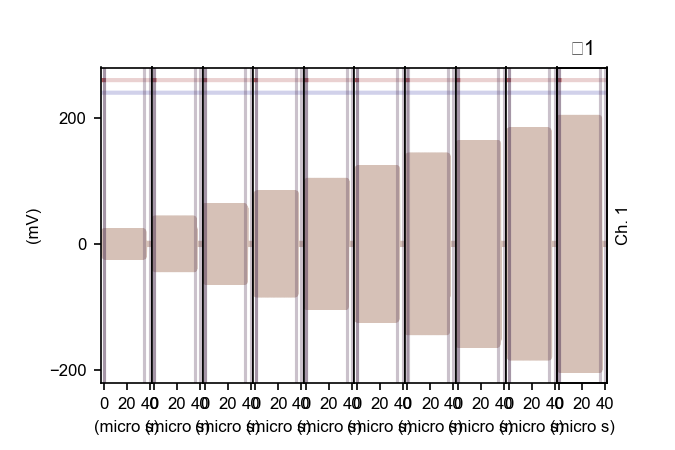

Waveforms done
['wfm_1_1_1', 'wfm_2_1_1', 'wfm_3_1_1', 'wfm_4_1_1', 'wfm_5_1_1', 'wfm_6_1_1', 'wfm_7_1_1', 'wfm_8_1_1', 'wfm_9_1_1', 'wfm_10_1_1']
True debug
[['wfm_1_1_1', 'wfm_10_1_1'], ['wfm_2_1_1'], ['wfm_3_1_1'], ['wfm_4_1_1'], ['wfm_5_1_1'], ['wfm_6_1_1'], ['wfm_7_1_1'], ['wfm_8_1_1'], ['wfm_9_1_1'], ['wfm_10_1_1']]


In [16]:
N = 10
pulse_times = [35e-6] * N
amplitudes = np.arange(N) * 0.02 + 0.02
frequencies = [1e6] * N
phases = np.arange(N) * 2 * np.pi/N
cycle_time = 40e-6

test_seq = AlazarTestSequence(station.awg)
test_seq.wait = 'off'
test_seq.setup_awg(pulse_times=pulse_times, frequencies=frequencies, 
                   phases=phases, amplitudes=amplitudes, 
                   cycle_time=cycle_time, pre_trig_time=0.1e-6, trig_time=0.1e-6,
                   plot=True)

# Test basic controllers

## Raw data

In [17]:
from line_profiler import LineProfiler

In [18]:
profile = LineProfiler(raw_acq.post_acquire)

In [19]:
ctl = raw_acq

t_rep = 40e-6
nsamples = 384 * 1
npts = int(1e6)
nrecords = 100
alloc_buffers = 5
SR = 1e7 * 1

t_total = npts * t_rep
nbuffers = npts // nrecords

In [22]:
t, data = acquisition_tools.time_acquisition(ctl, nsamples, nrecords, nbuffers, alloc_buffers=alloc_buffers, SR=SR, t_total=t_total)

Setup capture: 1536.0000000000002 MB total
 * Buffers: 10000 (0.15360000000000001 MB/buffer) | (Allocated buffers: 5 = 0.768 MB)
 * Records: 100 (0.001536 MB/record)
 * Samples: 384 (= 38.4 us)
 * Channels: 2
done: 0.35991587660467417 s
[1541760229.3084192] Waiting 5s for no reason.
[1541760229.6927145] Entering buffer wait loop.
[1541760234.295877] *TRG or something
[1541760269.6944406] Exited buffer wait loop.
Acquistion: 44.813618 sec.
Net time: 40.000000 sec.
Overhead: 1.12 X
Mean buffer handling time: 0.2 ms
post_acquire time: 4.39 s
Data shape: (1, 10000, 100, 384, 2)

 buffers cleared
buffers cleared
Captured 10000 buffers (249.800981 buffers per sec)
Captured 1000000 records (24980.098132 records per sec)
Transferred 1.536e+09 bytes (3.83694e+07 bytes per sec)
Pre setup took 0.3762043985411765
Pre capture setup took 0.0012819873687988093
Capture took 40.0052667540549
abort took 0.02449021085587333
handling took 1.4662455782854522e-06
free mem took 0.0006866916710350779
tot acqu

In [ ]:
profile.run('t, data = acquisition_tools.time_acquisition(ctl, nsamples, nrecords, nbuffers, alloc_buffers=alloc_buffers, SR=SR, t_total=t_total)')

In [15]:
profile.print_stats()

Timer unit: 4.88749e-07 s

Total time: 4.06396 s
File: d:\onedrive\bf2\code\pytopo\pytopo\rf\alazar\acquisition_controllers.py
Function: post_acquire at line 311

Line #      Hits         Time  Per Hit   % Time  Line Contents
   311                                               def post_acquire(self):
   312                                           
   313         1         11.0     11.0      0.0          t0 = time.perf_counter()
   314         1        587.0    587.0      0.0          data = super().post_acquire()
   315                                                   
   316         1          4.0      4.0      0.0          alz = self._alazar
   317         1        227.0    227.0      0.0          rng = np.array([alz.channel_range1(), alz.channel_range2()]).astype(np.float32)
   318                                                   # rng = rng.reshape((len(data.shape)-1)*(1,) + (2,))
   319         1      33126.0  33126.0      0.4          float_data = np.empty_like(data, dtype=n

<IPython.core.display.Javascript object>


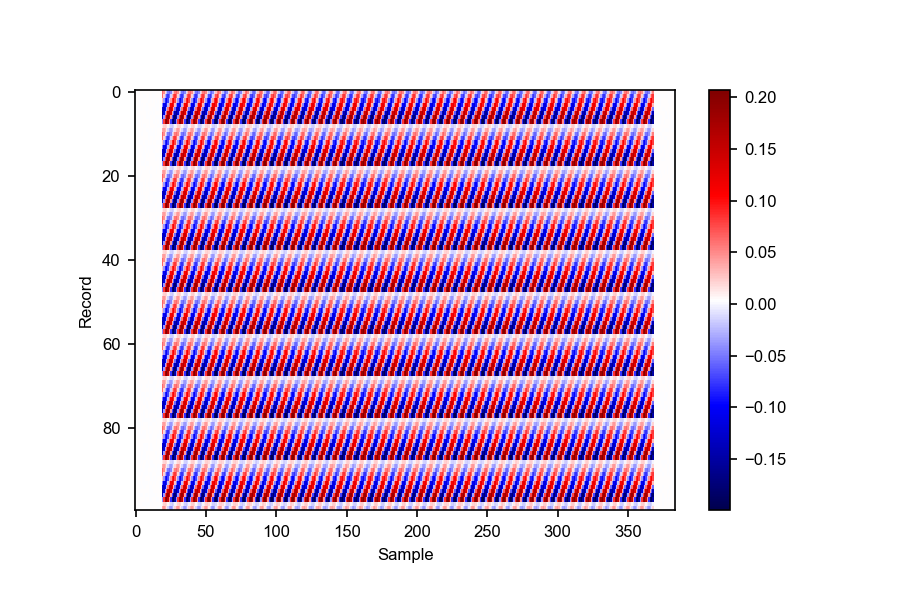

<IPython.core.display.Javascript object>


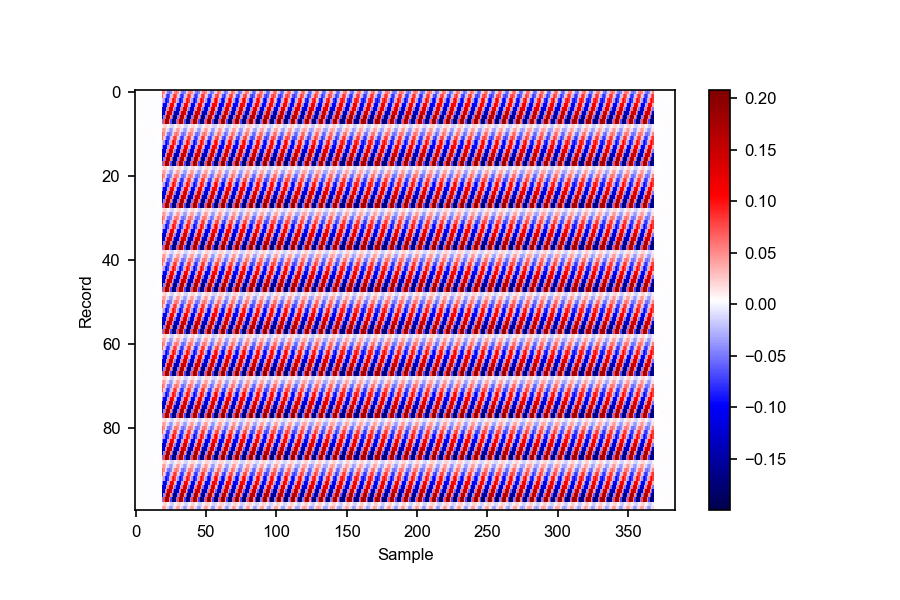

Text(0,0.5,'Record')

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.imshow(data[0, 0, :, :, 0], cmap=cm.seismic, aspect='auto')
cb = fig.colorbar(im)

ax.set_xlabel('Sample')
ax.set_ylabel('Record')

fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.imshow(data[0, -10, :, :, 0], cmap=cm.seismic, aspect='auto')
cb = fig.colorbar(im)

ax.set_xlabel('Sample')
ax.set_ylabel('Record')

In [14]:
async def f():
    return
f()

<coroutine object f at 0x0000029B307F1EB8>

In [16]:
# avgdata = data.mean(axis=0)

# fig, ax = plt.subplots(1, 1)
# ax.plot(avgdata[4, :, 0], 'o-')

In [17]:
# fig, ax = plt.subplots(1,1)
# ax.plot(ctl.handling_times, 'o')
# ax.set_xlabel('buffer')
# ax.set_ylabel('handling time (ms)')

In [17]:
import numba.config

In [21]:
numba.config.LOOP_VECTORIZE

True

## Post-acq. demodulation

### Only demodulation

In [ ]:
ctl = post_demod_acq
ctl.average_buffers(True)

demod_frq = 1e6
t_rep = 40e-6
nsamples = 3840 - 128
npts = int(1e4)
nrecords = 100
alloc_buffers = 10
SR = 1e8

t_total = npts * t_rep
nbuffers = npts // nrecords

t, data = acquisition_tools.time_acquisition(ctl, nsamples, nrecords, nbuffers, 
                                             alloc_buffers=alloc_buffers, 
                                             SR=SR, t_total=t_total)

print(f'post_acquire time: {ctl.post_acquire_time:.2f} s')
print('Data shape:', data.shape)

In [ ]:
iqdata = data.mean(axis=-2)
mag = np.abs(iqdata)
phase = np.angle(iqdata, deg=True)
phase[phase < -180] += 360

# fig, ax = plt.subplots(1,1)
# ax.plot(mag[0, :, 0], 'o-')
# ax.plot(mag[-1, :, 0] + 0.01, 'o-')

# fig, ax = plt.subplots(1,1)
# ax.plot(phase[0, :, 0], 'o-')
# ax.plot(phase[-1, :, 0]+50, 'o-')

fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
ax.plot(mag[0, 0, :, 0], 'o-')
bx.plot(phase[0, 0, :, 0], 'o-')
bx.set_xlabel('Record')
ax.set_ylabel('Magnitude (V)')
bx.set_ylabel('Phase (deg)')

### Extracting I/Q

In [ ]:
ctl = post_iq_acq
ctl.average_buffers(True)
ctl.buffers_per_block(None)
ctl.integration_start(1.25e-6)
ctl.integration_stop(11.25e-6)

demod_frq = 1e6
t_rep = 40e-6
nsamples = 3840 - 128
npts = int(1e4)
nrecords = 100
alloc_buffers = 10
SR = 1e8

t_total = npts * t_rep
nbuffers = npts // nrecords

t, data = acquisition_tools.time_acquisition(ctl, nsamples, nrecords, nbuffers, 
                                             alloc_buffers=alloc_buffers, 
                                             SR=SR, t_total=t_total)

print(f'post_acquire time: {ctl.post_acquire_time:.2f} s')
print('Data shape:', data.shape)

In [ ]:
mag = np.abs(data)
phase = np.angle(data, deg=True)
phase[phase < -180] += 360

# fig, ax = plt.subplots(1,1)
# ax.plot(mag[0, :, 0], 'o-')
# # ax.plot(mag[-1, :, 0] + 0.01, 'o-')

# fig, ax = plt.subplots(1,1)
# ax.plot(phase[0, :, 0], 'o-')
# # ax.plot(phase[-1, :, 0]+50, 'o-')

fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
ax.plot(mag[0, 0, :, 0], 'o-')
bx.plot(phase[0, 0, :, 0], 'o-')
bx.set_xlabel('Record')
ax.set_ylabel('Magnitude (V)')
bx.set_ylabel('Phase (deg)')

### Extracting IQ and usage of buffer blocks

In [ ]:
from pytopo.rf.alazar.awg_sequences import TriggerSequence

TriggerSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', None]
}
TriggerSequence.chan_settings = {
    1 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}

trig_seq = TriggerSequence(station.awg, SR=1e7)
trig_seq.wait = 'first'
trig_seq.setup_awg(cycle_time=1e-3, debug_signal=True, ncycles=6, plot=True)

In [ ]:
if AWGTYPE == '5208':
    station.awg.ch1.awg_amplitude(1.0)
else:
    station.awg.ch1_amp(1.0)

In [ ]:
class MyPostIQCtl(acquisition_controllers.PostIQCtl):
    
    def _perform_step(self, num):        
        awg = station.awg
        if AWGTYPE == '5208':
            while awg.run_state() != 'Waiting for trigger':
                time.sleep(0.01)
        else:
            while awg.get_state() != 'Waiting for trigger':
                time.sleep(0.01)
                   
        time.sleep(0.1)
        if not (num+1) % self.buffers_per_block():
            inc = (num+1) // self.buffers_per_block()
            if AWGTYPE == '5208':
                awg.ch1.awg_amplitude(0.25 + inc * 0.05)
            else:
                station.awg.ch1_amp(0.25 + inc * 0.05)
            time.sleep(0.01)     
            
        if AWGTYPE == '5208':
            awg.force_triggerA()
        else:
            awg.force_trigger()
        
    def pre_acquire(self):
        super().pre_acquire()
        self._perform_step(0)
        self._perform_step(1)
    
    def buffer_done_callback(self, buffernum):
        nextstep = buffernum + 2
        self._perform_step(nextstep)

my_iq_acq = instools.create_inst(MyPostIQCtl, 
                                 'my_iq_acq', 'alazar',
                                 allocate_samples=1e7, 
                                 force_new_instance=True)

In [ ]:
if AWGTYPE == '5208':
    station.awg.ch1.awg_amplitude(0.25)
else:
    station.awg.ch1_amp(0.25)

ctl = my_iq_acq
ctl.average_buffers(True)
ctl.buffers_per_block(10)

demod_frq = 1e6
t_rep = 1e-3
nsamples = 100e-6 * 1e8 // 128 * 128
nbuffers = 100
nrecords = 6
alloc_buffers = 10
SR = 1e8

t_total = nbuffers * t_rep

t, data = acquisition_tools.time_acquisition(ctl, nsamples, nrecords, nbuffers, 
                                             alloc_buffers=alloc_buffers, 
                                             SR=SR, t_total=t_total)

print(f'post_acquire time: {ctl.post_acquire_time:.2f} s')
print('Data shape:', data.shape)

In [ ]:
mag = np.abs(data)
phase = np.angle(data, deg=True)
phase[phase < -180] += 360

fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.imshow(mag[:, 0, :, 0], cmap=cm.seismic, aspect='auto')
cb = fig.colorbar(im)

ax.set_xlabel('Record')
ax.set_ylabel('Block')

# Using pytopo.sweep

## Test sequence

In [ ]:
N = 10
pulse_times = [35e-6] * N
amplitudes = np.arange(N) * 0.02 + 0.02
frequencies = [1e6] * N
phases = np.arange(N) * 2 * np.pi/N
cycle_time = 40e-6

test_seq = AlazarTestSequence(station.awg)
test_seq.wait = 'off'
test_seq.setup_awg(pulse_times=pulse_times, frequencies=frequencies, 
                   phases=phases, amplitudes=amplitudes, 
                   cycle_time=cycle_time, pre_trig_time=0.1e-6, trig_time=0.1e-6,
                   plot=True)

## Intro: remind ourselves what sweep does

In [ ]:
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_export import get_data_by_id

from pytopo.sweep.base import Nest, Chain
from pytopo.sweep.decorators import getter, setter
from pytopo.sweep import sweep, do_experiment, hardsweep, measure

In [ ]:
@setter(('a', 'M'), ('b', 'N'))
def set_stuff(a, b):
    print(f'Setting a = {a} and b = {b}')
    return a, b

@getter(('x', 'A'), ('y', 'B'))
def measure_stuff():
    print(f'Found x = 1, y = 10')
    return 1, 10

sweep_object = sweep(set_stuff, [(1, 2), (3, 4)])(
    measure(measure_stuff)
)

In [ ]:
for s in sweep_object:
    print(s)

## Simple Example: repeated time traces

In [ ]:
from qcodes.dataset import measurements; reload(measurements)

from pytopo.sweep import decorators; reload(decorators)
from pytopo.sweep.decorators import getter, setter, hardsweep
from pytopo.sweep import sweep, do_experiment, measure, call

it = Parameter('iteration', set_cmd=None, initial_value=1)

@hardsweep(ind=[('tvals', 'us', 'array')], dep=[('signal', 'V', 'array')])
def alazar_timetrace(setup_controller=True):
    time.sleep(0.5)
    print(f'Iteration: {it()+1}', end='\r')
    
    t_acq = 5e-6
    SR = 1e8
    
    station = qcodes.Station.default
    ctl = station.raw_acq
    ctl.buffers_per_block(None)
    
    with station.alazar.syncing():
        station.alazar.sample_rate(SR)
        
    if setup_controller:
        ctl.setup_acquisition(samples=int(t_acq * SR // 128 * 128), records=1,
                              buffers=2, verbose=False)
        
    data = np.squeeze(ctl.acquisition())[0,...,0]    
    return ctl.tvals.reshape(-1) * 1e6, data.reshape(-1)


so = sweep(it, range(20))(
    alazar_timetrace(),
)

result = do_experiment("test_hardsweep/None", so, live_plot=True)

In [ ]:
plot_by_id(result.run_id)

## Repeated IQ maps

In [ ]:
@hardsweep(
    ind=[('column', '', 'array'), ('row', '', 'array')], 
    dep=[('magnitude', 'V', 'array'), ('phase', 'deg', 'array')]
)
def alazar_iq_test(nrows=10, ncols=10, navgs=1, setup_controller=True):
    time.sleep(0.5)
    print(f'Iteration: {it()+1}', end='\r')
    
    t_acq = 15e-6
    SR = 1e8
    
    station = qcodes.Station.default
    ctl = station.post_iq_acq
    ctl.buffers_per_block(None)
    ctl.average_buffers(True)
    ctl.integration_start(1.25e-6)
    ctl.integration_stop(11.25e-6)
    
    with station.alazar.syncing():
        station.alazar.sample_rate(SR)
        
    if setup_controller:
        ctl.setup_acquisition(samples=int(t_acq * SR // 128 * 128), 
                              records=nrows*ncols,
                              buffers=navgs, verbose=False)
        
    data = ctl.acquisition()
    data = np.squeeze(data)[...,0].reshape(ncols, nrows)
    mag, phase = np.abs(data), np.angle(data, deg=True)
    cc, rr = np.meshgrid(np.arange(ncols), np.arange(nrows), indexing='ij')
    
    return ( np.vstack((cc.reshape(-1), rr.reshape(-1))), 
             np.vstack((mag.reshape(-1), phase.reshape(-1))) )


so = sweep(it, range(3))(
    alazar_iq_test(20, 20, 1),
)

result = do_experiment("test_hardsweep/None", so, live_plot=True)